In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1219.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1350.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_6378.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1494.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_907.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_730.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_697.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1476.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_700.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_8807.jpg
/kaggle/input/satellite-images-of-water-bodies/Water B

In [3]:
from functools import partial
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

In [4]:
images_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'
masks_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'

dirname, _, filenames = next(os.walk(images_dir))

In [5]:
@tf.function
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    return (image, mask)

In [6]:
@tf.function
def resize_images(images, masks, max_image_size=1500):
    shape = tf.shape(images)
    scale = (tf.reduce_max(shape) // max_image_size) + 1
    target_height, target_width = shape[-3] // scale, shape[-2] // scale
    images = tf.cast(images, tf.float32)
    masks = tf.cast(masks, tf.float32)
    if scale != 1:
        images = tf.image.resize(images, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        masks = tf.image.resize(masks, (target_height, target_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return (images, masks)

@tf.function
def scale_values(images, masks, mask_split_threshold = 128):
    images = tf.math.divide(images, 255)
    masks = tf.where(masks > mask_split_threshold, 1, 0)
    return (images, masks)

@tf.function
def pad_images(images, masks, pad_mul=16, offset=0):
    shape = tf.shape(images)
    height, width = shape[-3], shape[-2]
    target_height = height + tf.math.floormod(tf.math.negative(height), pad_mul)
    target_width = width + tf.math.floormod(tf.math.negative(width), pad_mul)
    images = tf.image.pad_to_bounding_box(images, offset, offset, target_height, target_width)
    masks = tf.cast(tf.image.pad_to_bounding_box(masks, offset, offset, target_height, target_width), tf.uint8)
    return (images, masks)

In [7]:
batch_size = 32
test_set_size = 300
validation_set_size = 250

dataset = tf.data.Dataset.list_files(images_dir + '/*.jpg', seed=42)

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.map(scale_values)
test_dataset = test_dataset.shuffle(20)
test_dataset = test_dataset.map(lambda img, mask: resize_images(img, mask, max_image_size=2500))
test_dataset = test_dataset.map(pad_images)
test_dataset = test_dataset.batch(1).prefetch(5)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.map(scale_values)
validation_dataset = validation_dataset.shuffle(20)
validation_dataset = validation_dataset.map(resize_images)
validation_dataset = validation_dataset.map(pad_images)
validation_dataset = validation_dataset.batch(1).prefetch(5)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.map(scale_values)
train_dataset = train_dataset.shuffle(20)
train_dataset = train_dataset.map(resize_images)
train_dataset = train_dataset.map(pad_images)
train_dataset = train_dataset.batch(1).prefetch(5)

2022-09-16 13:22:50.743443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 13:22:50.836877: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 13:22:50.837655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-16 13:22:50.839629: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [8]:
def get_unet(hidden_activation='relu', initializer='he_normal', output_activation='sigmoid'):
    PartialConv = partial(keras.layers.Conv2D,
     activation=hidden_activation,
     kernel_initializer=initializer,      
     padding='same')
    
    # Encoder
    model_input = keras.layers.Input(shape=(None, None, 3))
    enc_cov_1 = PartialConv(32, 3)(model_input)
    enc_cov_1 = PartialConv(32, 3)(enc_cov_1)
    enc_pool_1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_1)
    
    enc_cov_2 = PartialConv(64, 3)(enc_pool_1)
    enc_cov_2 = PartialConv(64, 3)(enc_cov_2)
    enc_pool_2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_2)
    
    enc_cov_3 = PartialConv(128, 3)(enc_pool_2)
    enc_cov_3 = PartialConv(128, 3)(enc_cov_3)
    enc_pool_3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(enc_cov_3)
    
    # Center
    center_cov = PartialConv(256, 3)(enc_pool_3)
    center_cov = PartialConv(256, 3)(center_cov)
    
    # Decoder
    upsampling1 = keras.layers.UpSampling2D(size=(2, 2))(center_cov)
    dec_up_conv_1 = PartialConv(128, 2)(upsampling1)
    dec_merged_1 = tf.keras.layers.Concatenate(axis=3)([enc_cov_3, dec_up_conv_1])
    dec_conv_1 = PartialConv(128, 3)(dec_merged_1)
    dec_conv_1 = PartialConv(128, 3)(dec_conv_1)
    
    upsampling2 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_1)
    dec_up_conv_2 = PartialConv(64, 2)(upsampling2)
    dec_merged_2 = tf.keras.layers.Concatenate(axis=3)([enc_cov_2, dec_up_conv_2])
    dec_conv_2 = PartialConv(64, 3)(dec_merged_2)
    dec_conv_2 = PartialConv(64, 3)(dec_conv_2)
    
    upsampling3 = keras.layers.UpSampling2D(size=(2, 2))(dec_conv_2)
    dec_up_conv_3 = PartialConv(32, 2)(upsampling3)
    dec_merged_3 = tf.keras.layers.Concatenate(axis=3)([enc_cov_1, dec_up_conv_3])
    dec_conv_3 = PartialConv(32, 3)(dec_merged_3)
    dec_conv_3 =  PartialConv(32, 3)(dec_conv_3)
    
    output = keras.layers.Conv2D(1, 1, activation=output_activation)(dec_conv_3)
    
    return tf.keras.Model(inputs=model_input, outputs=output)
    

In [9]:
model = get_unet()

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss='binary_crossentropy', optimizer=optimizer)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 3 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

epochs = 10
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_reduce])


2022-09-16 13:22:55.443176: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-16 13:22:59.164569: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2291/2291 [==============================] - 1324s 574ms/step - loss: 0.5711 - val_loss: 0.5009
Epoch 2/10
2291/2291 [==============================] - 262s 114ms/step - loss: 0.4935 - val_loss: 0.5032
Epoch 3/10
2291/2291 [==============================] - 145s 63ms/step - loss: 0.4293 - val_loss: 0.4050
Epoch 4/10
2291/2291 [==============================] - 135s 59ms/step - loss: 0.3928 - val_loss: 0.3629
Epoch 5/10
2291/2291 [==============================] - 131s 57ms/step - loss: 0.3819 - val_loss: 0.3754
Epoch 6/10
2291/2291 [==============================] - 128s 56ms/step - loss: 0.3807 - val_loss: 0.3508
Epoch 7/10
2291/2291 [==============================] - 126s 55ms/step - loss: 0.3756 - val_loss: 0.3804
Epoch 8/10
2291/2291 [==============================] - 129s 56ms/step - loss: 0.3704 - val_loss: 0.3724
Epoch 9/10
2291/2291 [==============================] - 127s 55ms/step - loss: 0.3652 - val_loss: 0.3520

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.000

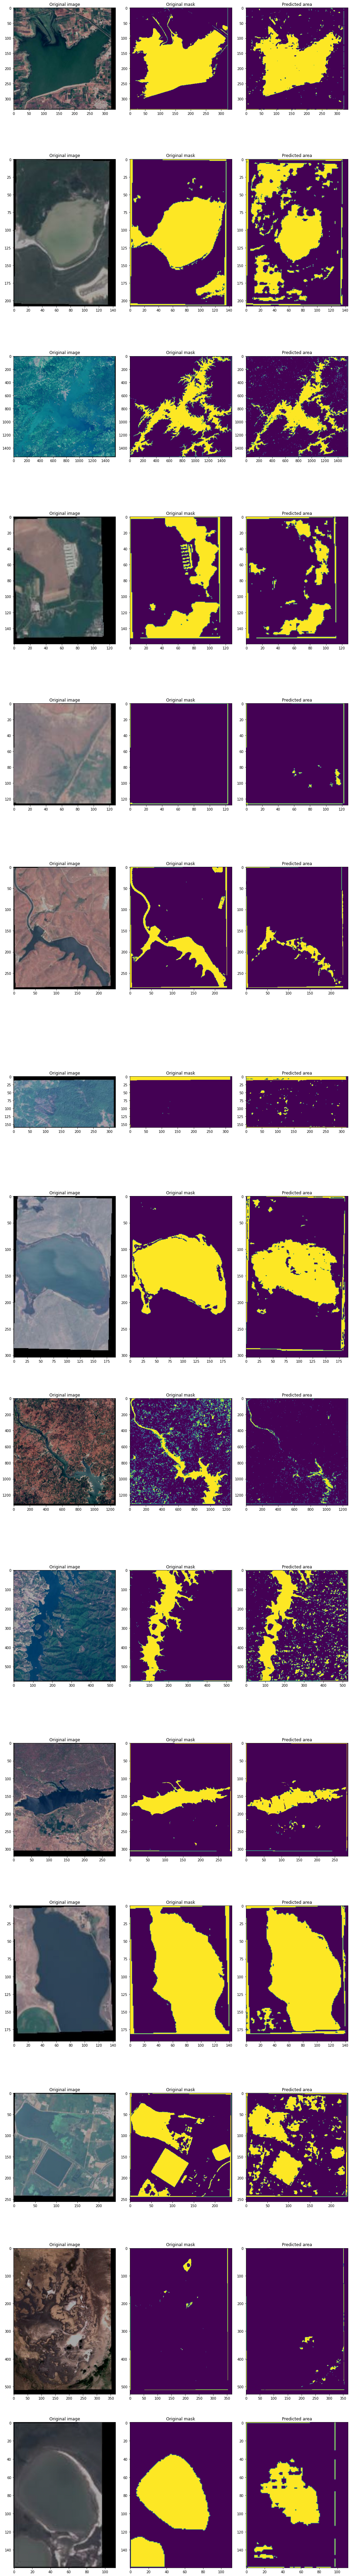

In [12]:
n_examples = 15

fig, axs = plt.subplots(n_examples, 3, figsize=(14, n_examples*7), constrained_layout=True)
for ax, ele in zip(axs, test_dataset.take(n_examples)):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 255, 0)
    ax[0].set_title('Original image')
    ax[0].imshow(image[0])
    ax[1].set_title('Original mask')
    ax[1].imshow(y_true[0])
    ax[2].set_title('Predicted area')
    ax[2].imshow(prediction)

In [13]:
meanIoU = tf.keras.metrics.MeanIoU(num_classes=2)
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    meanIoU.update_state(y_true[0], prediction)
print(meanIoU.result().numpy())

0.7051264


In [14]:
model.save("result.h5")

In [15]:
model.save_weights("/kaggle/working")